# ScoreAnalyzer 用於真實辨識情況下的範例

In [1]:
# Interactive Mode
%pylab inline
interactive(True)

Populating the interactive namespace from numpy and matplotlib


## 定義經常使用的視覺化函式

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 用來顯示圖片
def show(scale=3):
    plt.gcf().set_size_inches(plt.gcf().get_size_inches()*scale)
    plt.gcf().set_dpi(300)
    plt.show()
    plt.gcf().clear()

# 可以在圖片上畫出方塊
def draw_rect(min_c, max_c, style, linewidth=4, ax=None):
    min_x, min_y = min_c
    max_x, max_y = max_c
    
    if ax != None:
        ax.plot([min_x, min_x, max_x, max_x, min_x], [min_y, max_y, max_y, min_y, min_y], style, linewidth=linewidth)
    else:
        plt.plot([min_x, min_x, max_x, max_x, min_x], [min_y, max_y, max_y, min_y, min_y], style, linewidth=linewidth)

## 先選定圖片的路徑

In [3]:
no = 15
path = "../../data/score{:03d}.jpg".format(no)

print "選定的圖片路徑為：\"{}\"".format(path)

選定的圖片路徑為："../../data/score015.jpg"


變數data是一個1753x1240的矩陣：
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]]




圖片長這樣


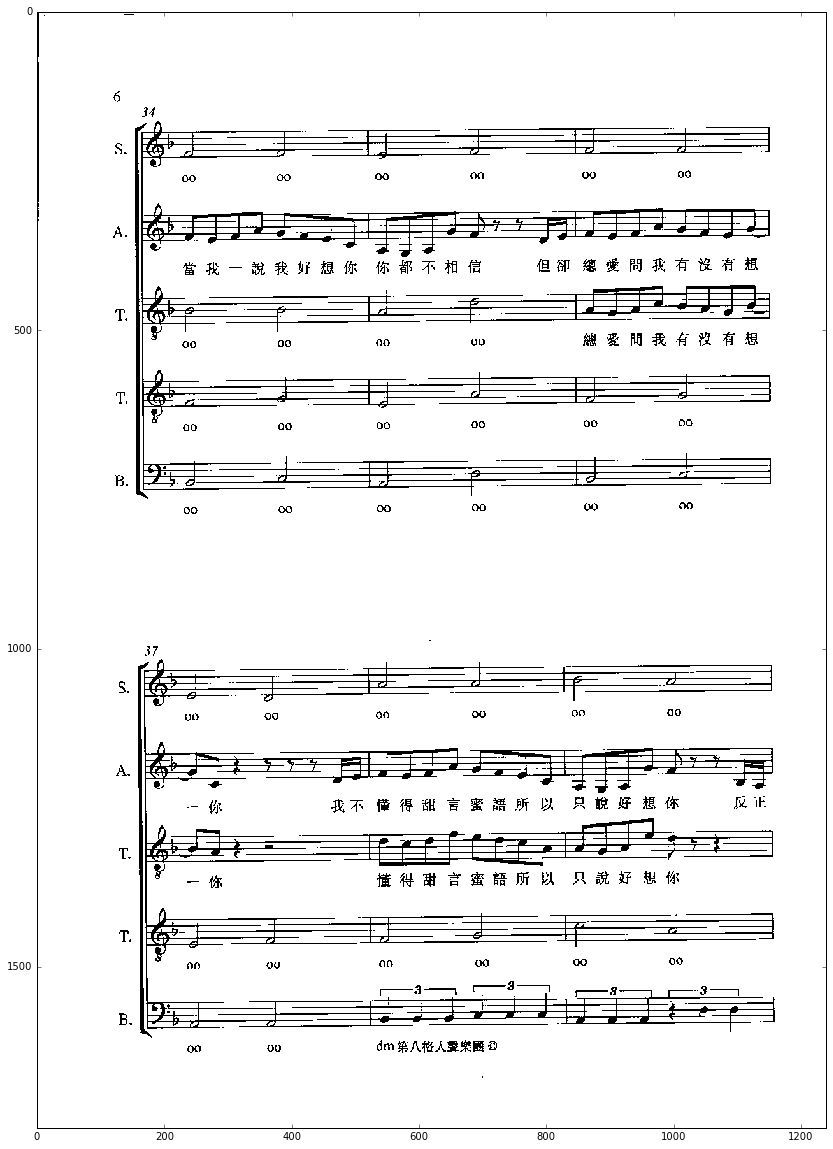

In [4]:
from ScoreAnalyzer.image import imagetools as it

data = it.load(path, thresh=.2, reverse=True)
print "變數data是一個{}x{}的矩陣：".format(*data.shape)
print data

print "\n\n\n"
print "圖片長這樣"
plt.imshow(data, cmap=plt.cm.binary, interpolation="nearest")
show(scale=5)

In [5]:
from ScoreAnalyzer.staffline import stafflineinfo as stfinfo
from ScoreAnalyzer.linefit import linefinder as lf
from ScoreAnalyzer.staffline import extractor as stfext

info = stfinfo.staffline_info(data)
height = 5*info["width"] + 4*info["space"] # 五線總高度為五個線寬以及四個線距
staff_center_lines = lf.find_lines_by_centers_RANSAC(info["centers"], 
                                             min_margin=height*1.5, 
                                             in_thresh=.2, 
                                             ang_thresh=0.005, 
                                             max_iter=10, 
                                             NRANSAC=200)

# 按照中心線的y截距大小重新排列
staff_center_lines = sorted(staff_center_lines, key=lambda x: x[1])

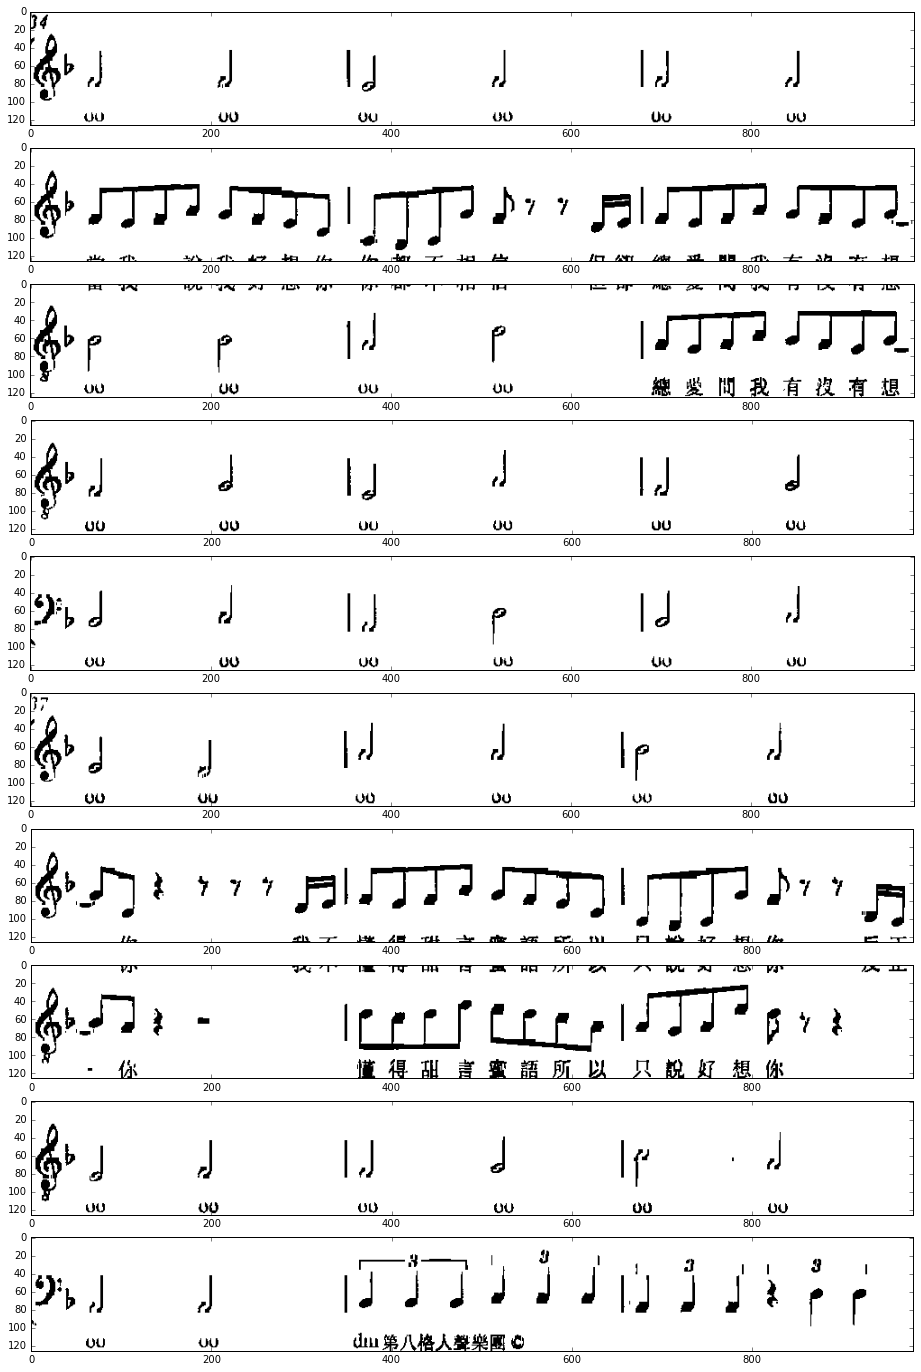

In [6]:
from ScoreAnalyzer.detector.utils import staff_tighten

# 根據五線中心線切割圖片
staff_images = it.segment_data(data=data, lines_params=staff_center_lines, margin=height*1.5, bin_thresh=.3, derotate=True)

# 再次確認圖片中是否涵蓋五線譜
staff_images = filter(lambda x: stfext.has_staffline(x, info["width"], info["space"]), staff_images)

# 分離五線與符號
staff_data = map(lambda image: stfext.extract_staffline(image, info["width"], info["space"], num_lines=11), staff_images)
symb_images, staff_only_images, yposes = zip(*staff_data)

# 清除五線譜樂句兩側多餘的空白空間
symb_images = map(staff_tighten, symb_images, staff_only_images, [4*info["width"]]*len(symb_images))

# 將處理後的圖片顯示出來
if len(symb_images) > 1:
    f, axes = plt.subplots(len(symb_images), 1)
    for i, image in enumerate(symb_images):
        axes[i].imshow(image, cmap=plt.cm.binary)
else:
    plt.imshow(symb_image[0], cmap=plt.cm.binary)
show(scale=6)

## 規劃好每一個 `measure_image` 的處理流程

In [7]:
from ScoreAnalyzer.detector.symbdetector import SymbolDetector
from ScoreAnalyzer.detector.utils import ypos_to_pitch_number

symbdtr = SymbolDetector(stfwidth=info["width"], stfspace=info["space"])
yc, margin = -1, -1

def detect(image):
    global yc
    global margin
    
    image = np.array(image)
    
    # Clef Detection
    clefs = symbdtr.find_clefs(image)
    yc, margin = clefs["y-center"], clefs["margin"]
    erase_detection(image, SymbolDetector.to_matrix(clef_matched=clefs))
    
    # Stem/Beam Detection
    bg = symbdtr.find_stems(image, clef_matched=clefs)
    
    # Notehead Detection
    nhs = symbdtr.find_noteheads_stem_guided(image, beamgroup=bg)
    erase_detection(image, SymbolDetector.to_matrix(notehead_matched=nhs))
    for idx, founded in enumerate(bg.stemnote_founded):
        if founded:
            minx, maxx, miny, maxy = bg.stems[idx]
            image[miny:maxy, minx:maxx] = 0
    
    # Rest Detection
    rests = symbdtr.find_rests(image)
    erase_detection(image, SymbolDetector.to_matrix(rest_matched=rests))
    
    # Accidental Detection
    accs = symbdtr.find_accidentals(image)
    
    # 將所有偵測結果堆疊起來回傳
    return SymbolDetector.to_matrix(clef_matched=clefs,
                                    notehead_matched=nhs,
                                    rest_matched=rests,
                                    acc_matched=accs)

def erase_detection(image, detection):
    for symbid, conf, minx, maxx, miny, maxy in detection:
        image[miny:maxy, minx:maxx] = 0

def annotate_detection(detection):
    for symbid, conf, minx, maxx, miny, maxy in detection:
        pi = ypos_to_pitch_number((miny+maxy)/2, yc, margin)
        anntext = "{}".format(symbdtr.SYMBID_TO_SYMB[symbid])
        if (symbid >= 3 and symbid <= 5) or symbid >= 13: anntext += "[{}]".format(pi)
        draw_rect([minx, miny], [maxx, maxy], "r--")
        plt.annotate(anntext, xy=((minx+maxx)/2, maxy+margin/2),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="b")

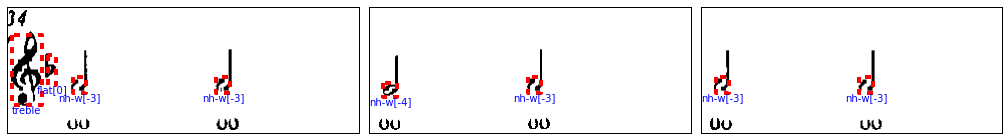

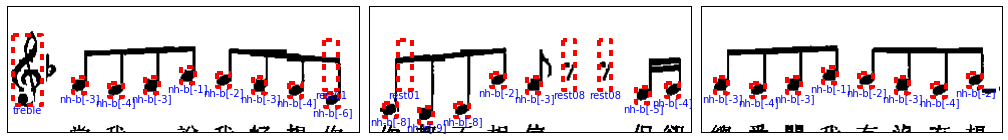

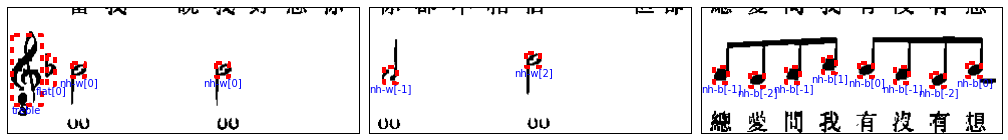

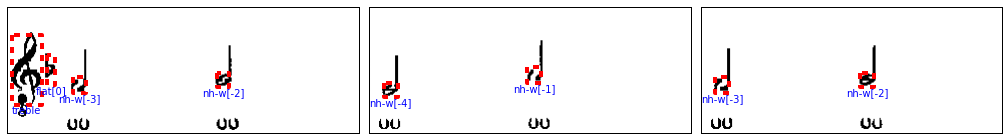

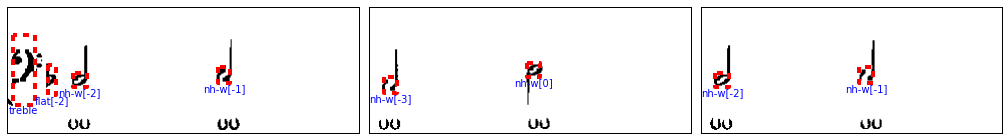

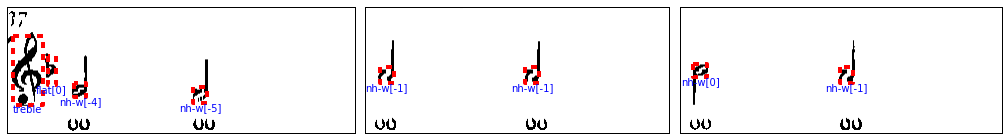

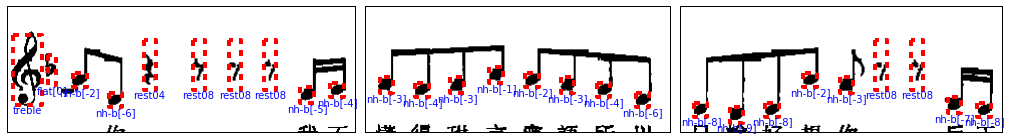

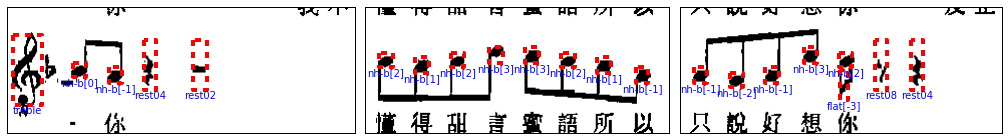

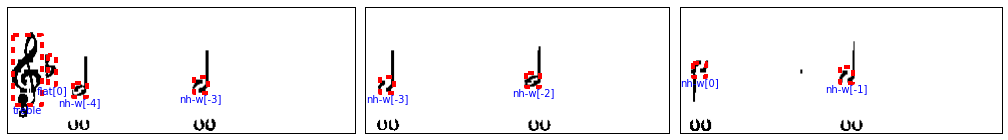

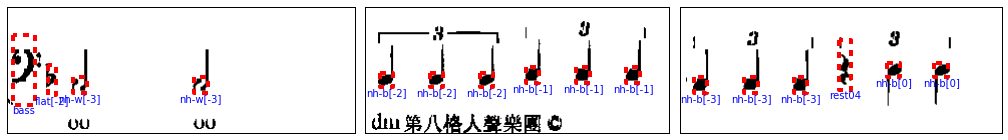

In [8]:
from ScoreAnalyzer.detector.utils import get_barline_positions

FIGURE_SPACING = 10

for symb_image in symb_images:
    # 偵測小節線的位置
    barlines = get_barline_positions(symb_image, info)
    
    # 根據小節線的位置來對圖做進一步的切割
    regions = [0] + barlines.flatten().tolist() + [symb_image.shape[1]]
    regions = np.reshape(regions, [len(regions)/2, 2])
    measure_images = map(lambda x: symb_image[:, x[0]:x[1]], regions)
    
    # 視覺化偵測結果
    offset = 0
    total_width = sum(map(lambda x: x.shape[1], measure_images)) + FIGURE_SPACING*len(measure_images)
    for measure_image in measure_images:
        plt.subplot2grid((1, total_width), (0, offset), colspan=measure_image.shape[1])
        
        annotate_detection(detect(measure_image)) # 標記偵測結果
        plt.imshow(measure_image, cmap=plt.cm.binary) # 畫出底圖
        
        # 將 xy 軸的數字清除
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        
        offset += measure_image.shape[1]+FIGURE_SPACING # 視覺化參數
        
    show(scale=3)